In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")
from tensorflow import keras
from sklearn.cluster import KMeans
import random
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from Data_Prepear import data_prepear
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
tf.__version__
from xgboost import XGBRegressor

2024-10-26 01:43:04.894115: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 01:43:04.897485: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 01:43:04.907034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 01:43:04.923439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 01:43:04.927974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 01:43:04.939455: I tensorflow/core/platform/cpu_feature_gu

In [3]:
# read the orginal data from the csv file
df1 = pd.read_csv("well3.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# df1 = df1[(df1["dp_tubing"] > 100) & (df1["bhp"] > 200) & (df1["bht"] > 80)]
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2014-04-21', periods=717, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')

df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2014-04-21,0.0,0.0,42.451498,58.246959,26266.34,0
2014-04-22,0.0,0.0,50.739130,35.053212,19735.05,1
2014-04-23,0.0,0.0,47.291893,40.929719,21458.08,2
2014-04-24,0.0,0.0,40.996606,51.555185,28707.40,3
2014-04-25,0.0,0.0,40.604959,49.298888,23251.90,4


In [6]:
create_data = data_prepear(df, target_col ="QG", filter_value=50)
X_train, y_train, X_test, y_test = create_data.creator()

In [7]:
# Normalize features 
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (32,1), units= 32, return_sequences = True))
model.add(LSTM(128, activation="relu",return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation="relu",return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))
# model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 32, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,217 (1.16 MB)

 Trainable params: 305,217 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_loss',          # Metric to monitor (you can change it)
    save_best_only=True,         # Only save the best model (based on the monitored metric)
    mode='min',                  # 'min' because we want to minimize validation loss
    verbose=1                    # Verbosity mode, to see saving details in console
)
t1 = datetime.datetime.now()
history = model.fit(x=X_train, y=y_train["y_step_1 QG"], epochs=1000, batch_size=30, validation_data = (X_test, y_test["y_step_1 QG"]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100), checkpoint], verbose=1, shuffle=False)
# EarlyStopping(monitor='val_loss', patience=200), 
t2 = datetime.datetime.now()
print("Compilation Time : ", t2-t1)

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8814
Epoch 1: val_loss improved from inf to 2.23817, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.8694 - val_loss: 2.2382
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3162
Epoch 2: val_loss improved from 2.23817 to 2.13500, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3167 - val_loss: 2.1350
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3806
Epoch 3: val_loss did not improve from 2.13500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.3778 - val_loss: 2.2254
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3788
Epoch 4: val_loss improved from 2.13500 to 2.08584, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.3759 - val_loss: 2.0858
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4431
Epoch 5: val_loss improved from 2.08584 to 2.03351, saving model t

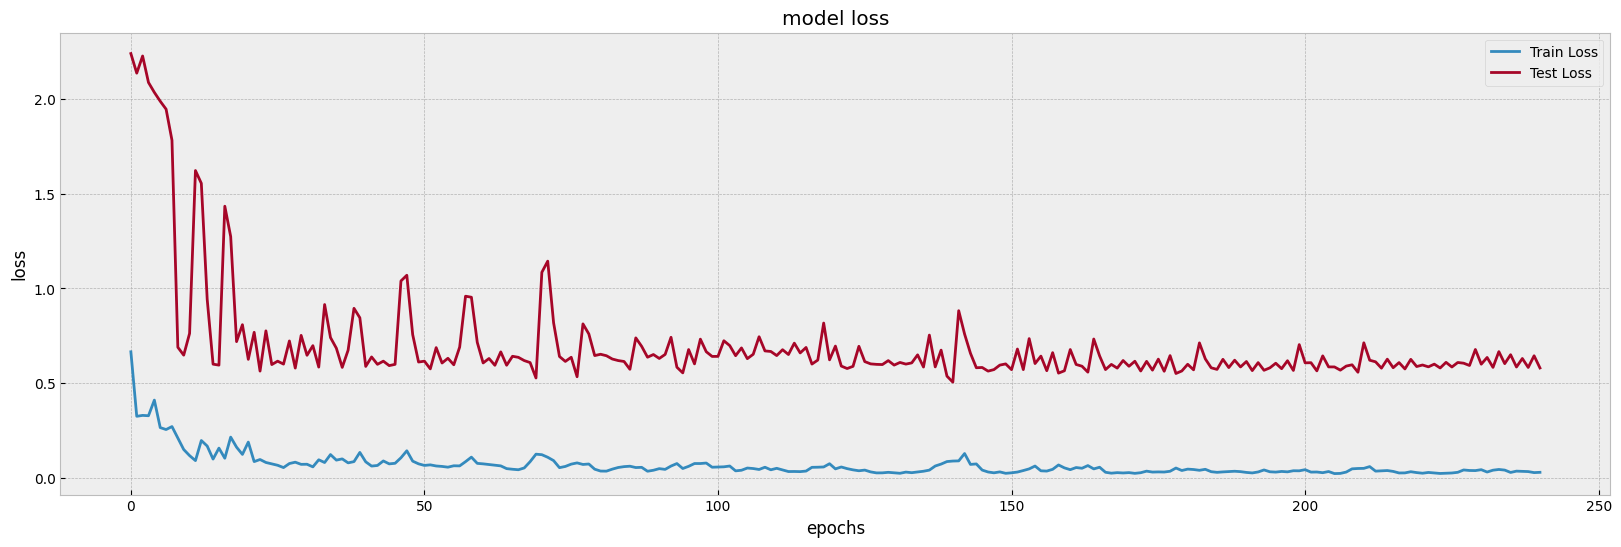

In [9]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [10]:
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [11]:
ss = StandardScaler()
ss.fit(df.QG.values.reshape(df.QG.shape[0],1))
true_y_train = ss.inverse_transform(y_train["y_step_1 QG"].values.reshape(y_train["y_step_1 QG"].shape[0],1))
true_y_test = ss.inverse_transform(y_test["y_step_1 QG"].values.reshape(y_test["y_step_1 QG"].shape[0],1))
true_y_fit = ss.inverse_transform(y_fit)
true_y_pred = ss.inverse_transform(y_pred)

In [12]:
train_rmse = mean_squared_error(true_y_train, true_y_fit, squared=False)
test_rmse = mean_squared_error(true_y_test , true_y_pred, squared=False)
range_train =  np.max(true_y_train) - np.min(true_y_train)
range_test = np.max(true_y_test) - np.min(true_y_test)
print("train RMSE: ",train_rmse)
print("train Range:",range_train)
print("Percent_Erorr:", (train_rmse/range_train)*100, "%")
print("test_RMSE: ", test_rmse)
print("test Range:",range_test)
print("Percent_Erorr:", (test_rmse/range_test)*100, "%")

train RMSE:  7573.06891628973
train Range: 155248.83
Percent_Erorr: 4.878019960787936 %
test_RMSE:  24525.608233692346
test Range: 157517.8646292135
Percent_Erorr: 15.570048699824609 %


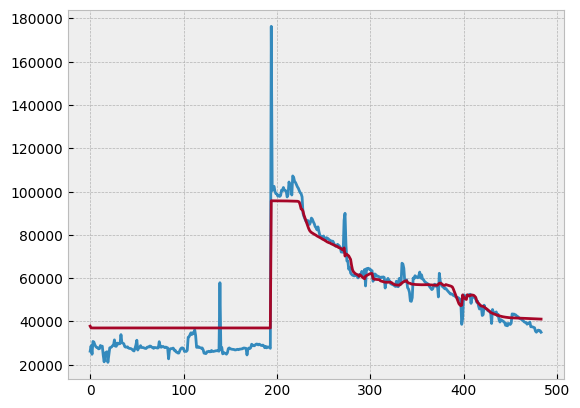

In [13]:
plt.plot(true_y_train)
plt.plot(true_y_fit)

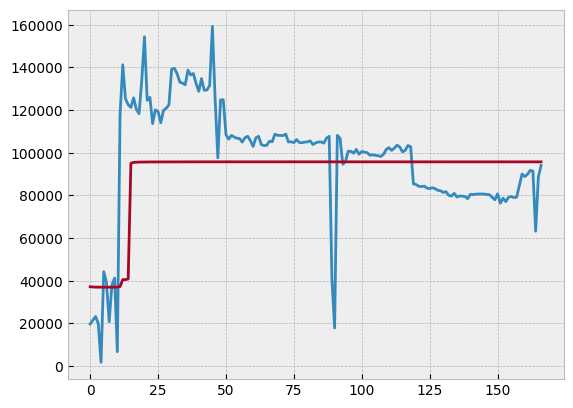

In [14]:
plt.plot(true_y_test)
plt.plot(true_y_pred)

[Text(0.5, 1.0, 'Train'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

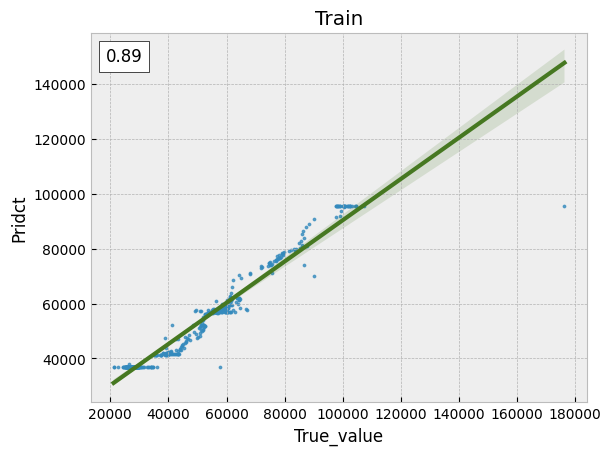

In [15]:
corr = r2_score(true_y_train, true_y_fit)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_train,
    y = true_y_fit,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="Train", xlabel="True_value", ylabel="Pridct")

[Text(0.5, 1.0, 'test'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

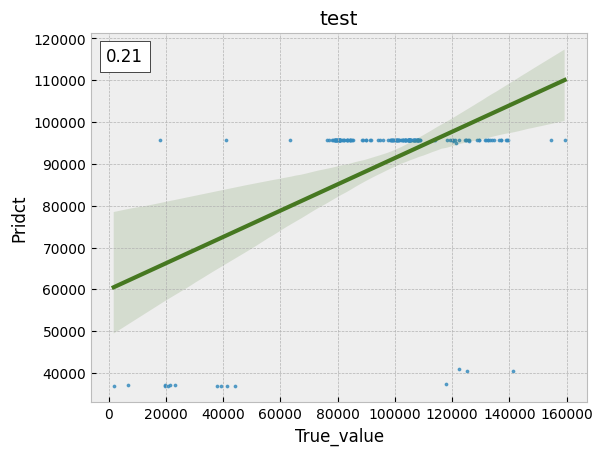

In [16]:
corr = r2_score(true_y_test, true_y_pred)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_test,
    y = true_y_pred,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="test", xlabel="True_value", ylabel="Pridct")